## Import necessary packages tutorial

In [1]:
import renom as rm
from renom.utility.initializer import Uniform, GlorotUniform
import gym

/Users/thakur/ReNom/renom/cuda/__init__.py:12: UserWarning: Couldn't find cuda modules. No module named 'renom.cuda.cuda_base'
  warnings.warn("Couldn't find cuda modules. %s" % e)
/Users/thakur/ReNom/renom/cuda/__init__.py:29: UserWarning: Couldn't find cuda modules.
  warnings.warn("Couldn't find cuda modules.")


## Deifne the environment tutorial

In [2]:
env = gym.make('Pendulum-v0')

[2018-03-22 11:37:00,136] Making new env: Pendulum-v0


## Define the actor network tutorial

In [3]:
class Actor(rm.Model):
    
    '''Here considered 3-layer network (excluding input layer). Feel free to change the network depth 
    and check the results. The output-layer number of nuerons are equal to number of actions.
    In the example of OpenAI Gym's Pendlum-v0 environment number of actions are 1.'''
    
    def __init__(self, env, layer_size):
        self._layers = []
        self.env = env
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(self.env.action_space.shape[0], initializer=Uniform(min=-0.003, max=0.003))
        self._layers = [self._l1, self._l2, self._l3]
    
    def forward(self, x):
        '''Neural Network inputs are state information, outputs are actions. '''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(h1))
        h3 = rm.tanh(self._l3(h2)) 
        #h = self._l3(h2)
        h = h3*self.env.action_space.high[0]
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay


# Define the Critic network tutorial

In [4]:
class Critic(rm.Model):
    '''Here considered a 3-layer network (input layer, hidden layer-1, hidden layer-2, output layer)
        At input-layer state information, 2nd-hidden layer actions are applied, last layer has a single neuron'''
    def __init__(self, env, layer_size):        
        self._layers = []
        self.env = env
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(1, initializer=Uniform(min=-0.003, max=0.003))
        self._layers = [self._l1, self._l2, self._l3]
  
    def forward(self, x, action):
        '''Q(s,a) calculation for a given (state, action) pair'''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(rm.concat(h1,action))) # actions are applied at 2nd hidden layer
        h = self._l3(h2)        
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay

## Instantiating the actor & ciritic networks 

In [5]:
from renom.algorithm.reinforcement.ddpg import DDPG
layer_size = [400, 300] # two-hidden layers dimension
actor_network = Actor(env=env,layer_size=layer_size)
critic_network = Critic(env=env, layer_size=layer_size)

## Instantiating the DDPG class

In [6]:
ddpg = DDPG(env=env, actor_network=actor_network, critic_network=critic_network)
# ddpg = DDPG(env=env) # for default

## Training 

In [7]:
[reward_list, loss_list]=ddpg.train(num_episodes=300)

episode: 000 Total reward:-1067.34 avg loss:1.9978: 100%|██████████| 200/200 [00:04<00:00, 28.37it/s]
episode: 001 Total reward:-1053.26 avg loss:0.1396: 100%|██████████| 200/200 [00:07<00:00, 26.23it/s]
episode: 002 Total reward:-1203.82 avg loss:0.0182: 100%|██████████| 200/200 [00:08<00:00, 24.66it/s]
episode: 003 Total reward:-1306.76 avg loss:0.0130: 100%|██████████| 200/200 [00:08<00:00, 24.93it/s]
episode: 004 Total reward:-1883.34 avg loss:0.0149: 100%|██████████| 200/200 [00:07<00:00, 30.13it/s]
episode: 005 Total reward:-1599.71 avg loss:0.0104: 100%|██████████| 200/200 [00:07<00:00, 28.27it/s]
episode: 006 Total reward:-1533.02 avg loss:0.0165: 100%|██████████| 200/200 [00:06<00:00, 28.69it/s]
episode: 007 Total reward:-1340.23 avg loss:0.0330: 100%|██████████| 200/200 [00:07<00:00, 26.51it/s]
episode: 008 Total reward:-1521.55 avg loss:0.0486: 100%|██████████| 200/200 [00:06<00:00, 28.87it/s]
episode: 009 Total reward:-1544.06 avg loss:0.0726: 100%|██████████| 200/200 [00:0

episode: 080 Total reward:-1496.69 avg loss:11.2435: 100%|██████████| 200/200 [00:08<00:00, 23.69it/s]
episode: 081 Total reward:-129.71 avg loss:11.8206: 100%|██████████| 200/200 [00:07<00:00, 25.64it/s]
episode: 082 Total reward:-87.41 avg loss:11.3901: 100%|██████████| 200/200 [00:08<00:00, 24.04it/s]
episode: 083 Total reward:-261.50 avg loss:9.1519: 100%|██████████| 200/200 [00:07<00:00, 27.59it/s]
episode: 084 Total reward:-565.37 avg loss:11.3206: 100%|██████████| 200/200 [00:07<00:00, 25.38it/s]
episode: 085 Total reward:-1591.56 avg loss:11.2090: 100%|██████████| 200/200 [00:07<00:00, 26.07it/s]
episode: 086 Total reward:-2.29 avg loss:11.9472: 100%|██████████| 200/200 [00:07<00:00, 28.29it/s]
episode: 087 Total reward:-379.76 avg loss:9.8591: 100%|██████████| 200/200 [00:07<00:00, 26.33it/s]
episode: 088 Total reward:-131.92 avg loss:7.6227: 100%|██████████| 200/200 [00:07<00:00, 25.27it/s]
episode: 089 Total reward:-268.93 avg loss:12.5112: 100%|██████████| 200/200 [00:07<00

episode: 160 Total reward:-252.73 avg loss:14.9896: 100%|██████████| 200/200 [00:08<00:00, 24.04it/s]
episode: 161 Total reward:-339.90 avg loss:19.2472: 100%|██████████| 200/200 [00:08<00:00, 23.85it/s]
episode: 162 Total reward:-122.50 avg loss:16.2698: 100%|██████████| 200/200 [00:08<00:00, 23.98it/s]
episode: 163 Total reward:-245.02 avg loss:15.6427: 100%|██████████| 200/200 [00:08<00:00, 23.79it/s]
episode: 164 Total reward:-120.88 avg loss:17.6257: 100%|██████████| 200/200 [00:08<00:00, 23.93it/s]
episode: 165 Total reward:-318.76 avg loss:14.9811: 100%|██████████| 200/200 [00:08<00:00, 23.82it/s]
episode: 166 Total reward:-247.54 avg loss:17.5621: 100%|██████████| 200/200 [00:08<00:00, 23.79it/s]
episode: 167 Total reward:-243.58 avg loss:17.7786: 100%|██████████| 200/200 [00:08<00:00, 23.88it/s]
episode: 168 Total reward:-118.15 avg loss:16.2490: 100%|██████████| 200/200 [00:08<00:00, 23.91it/s]
episode: 169 Total reward:-124.49 avg loss:16.0630: 100%|██████████| 200/200 [00:0

episode: 240 Total reward:-2.55 avg loss:14.4922: 100%|██████████| 200/200 [00:06<00:00, 28.40it/s]
episode: 241 Total reward:-123.08 avg loss:19.5476: 100%|██████████| 200/200 [00:06<00:00, 29.91it/s]
episode: 242 Total reward:-127.02 avg loss:17.3855: 100%|██████████| 200/200 [00:06<00:00, 28.39it/s]
episode: 243 Total reward:-120.28 avg loss:22.0193: 100%|██████████| 200/200 [00:06<00:00, 29.35it/s]
episode: 244 Total reward:-2.21 avg loss:15.9268: 100%|██████████| 200/200 [00:06<00:00, 30.32it/s]
episode: 245 Total reward:-132.38 avg loss:17.0091: 100%|██████████| 200/200 [00:06<00:00, 30.07it/s]
episode: 246 Total reward:-129.28 avg loss:19.7848: 100%|██████████| 200/200 [00:07<00:00, 26.41it/s]
episode: 247 Total reward:-118.90 avg loss:16.0862: 100%|██████████| 200/200 [00:08<00:00, 26.57it/s]
episode: 248 Total reward:-1.89 avg loss:13.5054: 100%|██████████| 200/200 [00:07<00:00, 26.61it/s]
episode: 249 Total reward:-236.25 avg loss:11.9966: 100%|██████████| 200/200 [00:07<00:0

## Testing

In [8]:
test_reward_list = ddpg.test(render=False,episodes=10)

episode: 009 Total reward:-1.39: 100%|██████████| 200/200 [00:00<00:00, 294.78it/s]    


## Plotting the test result

Text(0,0.5,'Total Rewards per Episode')

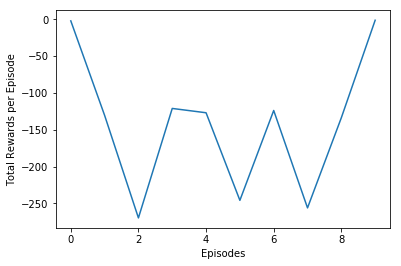

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards per Episode")